In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd
from memory_profiler import memory_usage

from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split
#from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from PIL import Image, ImageOps
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')


#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        #print(labels)
        #tensor_tmp = torch.tensor(labels.values, dtype=torch.float32)
        #self.labels = tensor_tmp
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        #new_image = np.empty((3, 46, 46)) #I NEED TO CHANGE MY IMAGE SIZES!!!!!!
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        #label = self.labels.iloc[idx].to_dict()
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        #print(sample)
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [3]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [4]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        if(not cluster):
            self.model = EfficientNet.from_pretrained('efficientnet-b0',  num_classes=n_classes)
            torch.save(self.model.state_dict(), 'initial_model.pt')
        else:
            self.model = EfficientNet.from_name('efficientnet-b0',  num_classes=n_classes)
            self.model.load_state_dict(torch.load('initial_model.pt'))

    def forward(self, x):
        x = self.model(x)
        return x

In [5]:
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

model = ViTBase16(n_classes=14, pretrained=True)

criterion = torch.nn.MSELoss() #nn.CrossEntropyLoss() #nn.CrossEntropyLoss() #nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

name = 'model2.pt'#'model.pt'#'other.pt' 
model = torch.load(name, map_location=torch.device('cpu'))

Loaded pretrained weights for efficientnet-b0
cpu


In [6]:
num_workers = 0

# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/Jack_Y6/'
hdu_list = fits.open(path_cutouts + 'Cutouts/Jack_Y6.fits')
images = hdu_list[1].data.astype(np.float32)
data = Table(hdu_list[2].data).to_pandas()
data = data.drop(['TILENAME'], axis=1)
hdu_list.close()
print('All sample: ', len(data))

data_not = pd.read_csv(path_cutouts + 'not_in_cutouts.csv')
data_not = data_not.astype({'COADD_OBJECT_ID': int})

new_data = pd.merge(data, data_not, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
images = images[new_data.index]
data = data.iloc[new_data.index].reset_index(drop=True)

print('With lensing features inside of cutout: ', len(data))

dataset = ImageDataset(images, data, np.zeros(len(data), dtype = np.float32), transform=transform)

All sample:  246
With lensing features inside of cutout:  140


In [7]:
def testing_analysis(test_loader):
    predicted_data, true_data = pd.DataFrame(), pd.DataFrame()
    for i, sample in enumerate(tqdm(test_loader)):
        data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
        # move tensors to GPU if CUDA is available
        if device.type == "cuda":
            data, target = data.cuda(), target.cuda()

        #forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        output = pd.DataFrame(output.detach().numpy())
        
        predicted_data = predicted_data.append(output)
        true_data = true_data.append(pd.DataFrame(sample_data))
        
    return(predicted_data.reset_index(drop=True), true_data.reset_index(drop=True))

In [8]:
test_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=20, num_workers=num_workers, shuffle=True)

test_dataset = test_loader.dataset
test_images, test_data = test_dataset.images, test_dataset.data.reset_index(drop=True)

predicted_data, true_data = testing_analysis(test_loader)

my_types = {'COADD_OBJECT_ID': int, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': float, 'IMAFLAGS_ISO_R': float, 'IMAFLAGS_ISO_I': float,
       'IMAFLAGS_ISO_Z': float, 'rank': int, 'num_sources': int, 'num_lenses': int, 'mem_match_id': int,
       'einstein_radius': float, 'einstein_radius_err': float, 'ACT': int, 'BBNA': int, 'BNA': int, 'TI': int,
       'RNA': int, 'RNA2': int, 'redM': float, 'redM_missed': float, 'SPTPol': float}
true_data = true_data.astype(my_types)

  0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
new_test_data = pd.DataFrame(columns = true_data.columns)

for i in range(len(true_data)):
    row = test_data[test_data['COADD_OBJECT_ID'] == true_data['COADD_OBJECT_ID'].iloc[i]]
    new_test_data = new_test_data.append(row)
    
test_data = new_test_data
test_images = test_images[test_data.index]
test_data = test_data.reset_index(drop=True)

In [10]:
names = ['EINSTEIN_RADIUS', 'e1_lens', 'e2_lens', 'center_x_lens', 'center_y_lens', 'R_sersic_source_light',
       'n_sersic_source_light', 'e1_source_light', 'e2_source_light', 'center_x_source', 'center_y_source', 
        'R_sersic_lens_light', 'e1_lens_light', 'e2_lens_light']
column_mapping = {old_column: new_column for old_column, new_column in enumerate(names)}
predicted_data.rename(columns=column_mapping, inplace=True)

loss_value = list((predicted_data['EINSTEIN_RADIUS']-true_data['einstein_radius'])**2)

test_data['loss_EINSTEIN_RADIUS'] = loss_value
test_data['pred_EINSTEIN_RADIUS'] = list(predicted_data['EINSTEIN_RADIUS'])

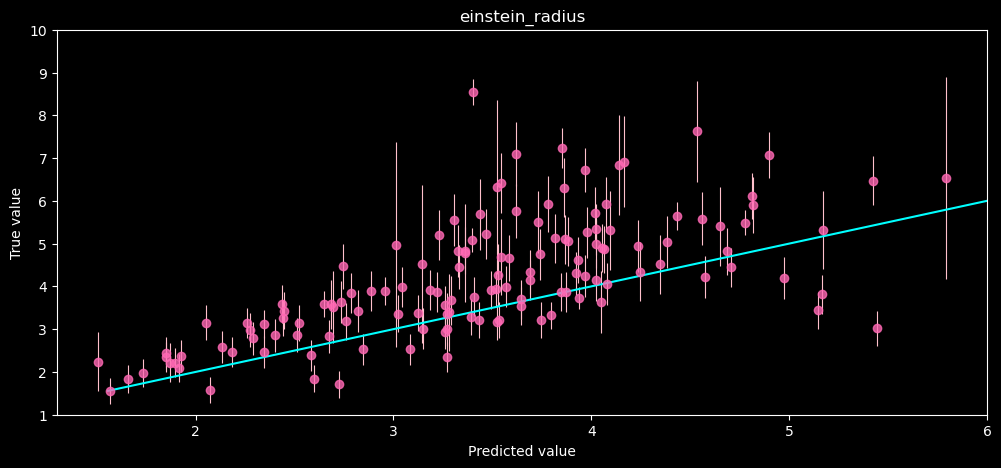

In [11]:
name = 'einstein_radius'
x = np.linspace(min(true_data[name]), max(true_data[name]), 1000)
    
plt.figure(figsize=(12, 5))
plt.title(name)
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.xlim(1.3, 6)
plt.ylim(1, 10)
plt.plot(x, x, color='#00FFFF')
plt.plot(predicted_data['EINSTEIN_RADIUS'], true_data[name], 'o', alpha = 0.8, color='#FF69B4')
plt.errorbar(predicted_data['EINSTEIN_RADIUS'], true_data[name], yerr=true_data['einstein_radius_err'], fmt='none', ecolor='#FFC0CB', elinewidth=0.8)
plt.show()

In [12]:
def make_plot_all(objects, title, data, Q, stretch, minimum):
    for i in range(len(objects)):
        if(i%8 == 0):
            plt.figure(figsize=(12,2))
            for j in range(8):
                if(i+j > len(objects)-1): break
                plt.subplot(1,8,j+1)
                #title = '{:.2f}'.format(data['loss_EINSTEIN_RADIUS'].iloc[i+j])    
                title = 'T:{:.1f}  P:{:.1f}'.format(data['einstein_radius'].iloc[i+j], data['pred_EINSTEIN_RADIUS'].iloc[i+j])
                plt.title(title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], 
                                    Q=Q, stretch=stretch, minimum=minimum)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            #plt.savefig(png_filepath + title + '.png', bbox_inches='tight')
            plt.show() 

Worst:


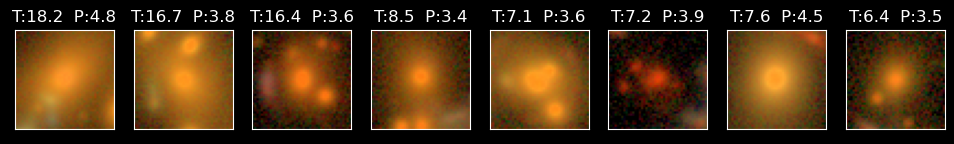

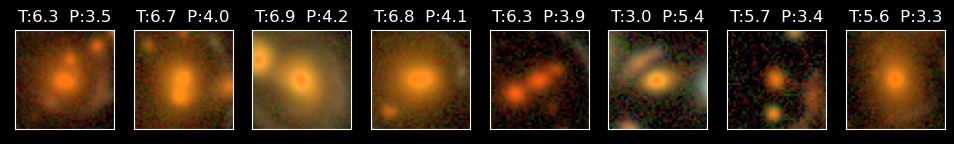

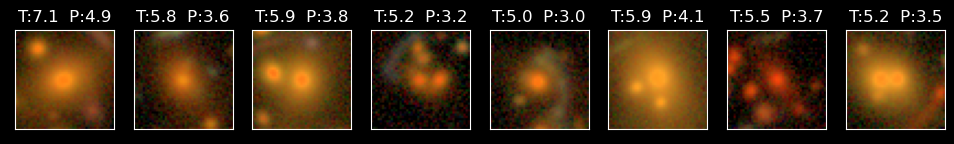

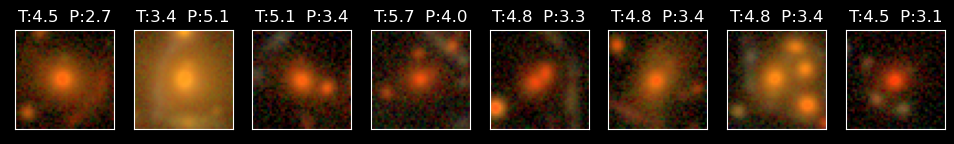

Best:


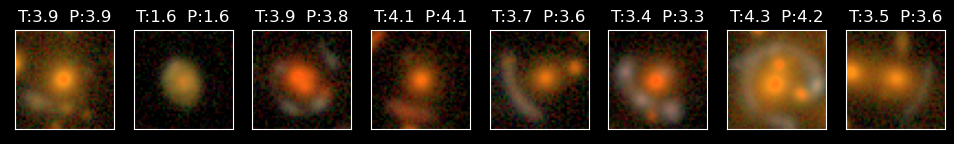

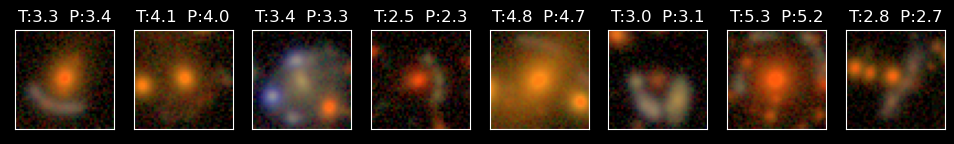

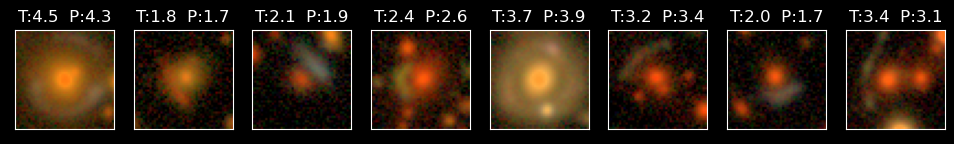

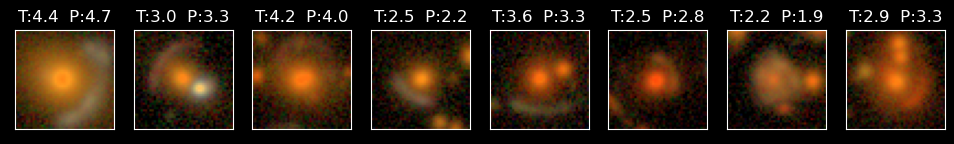

In [13]:
print('Worst:')
worst_data = test_data.nlargest(32, 'loss_EINSTEIN_RADIUS').sort_values(by='loss_EINSTEIN_RADIUS', ascending=False)
worst_images = test_images[worst_data.index]
make_plot_all(worst_images, 'title', worst_data, 9, 40, (0, 0, 0))

print('Best:')
worst_data = test_data.nsmallest(32, 'loss_EINSTEIN_RADIUS').sort_values(by='loss_EINSTEIN_RADIUS', ascending=True)
worst_images = test_images[worst_data.index]
make_plot_all(worst_images, 'title', worst_data, 9, 40, (0, 0, 0))